# P3 - Behavioral Cloning

In [1]:
import os.path
import csv
import glob
import json
import random
import time 

import numpy as np
import matplotlib.pyplot as plt

import cv2

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from keras.optimizers import Adam, RMSprop
from keras.layers.core import Dense, Activation
from keras.layers import Dense, Activation, Dropout,Conv2D,Convolution2D,MaxPooling2D,Flatten,Lambda
from keras.models import Sequential, Model
from keras import backend as K
from keras.regularizers import l2
from keras import callbacks
from keras.models import model_from_json

import pandas as pd


%matplotlib inline
plt.figure(figsize=(8,6))
#plt.rcParams['figure.figsize'] = 15, 20


print('--- done ---')

Using TensorFlow backend.
/Users/sebastienvincent/.virtualenvs/nd013/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/Users/sebastienvincent/.virtualenvs/nd013/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


--- done ---


### Check Keras init, CPU / GPU

In [2]:
from keras import __version__ as keras_version
print('Keras version:', keras_version)

Keras version: 1.2.1


In [3]:
#https://stackoverflow.com/a/45905793/3563822
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1210447853062222587
]


## DATA EXPLORATION

- all images are stored in data/IMG/
- `driving_log.csv` contains the paths of acquired images (for training) and the corresponding parameter values:
    
    *center_camera, left_camera, right_camera, steering_angle, throttle, brake, speed *

In [4]:
DATA_PATH, has_header = 'data/', True
#DATA_PATH, has_header = 'CarNDTrackData2/', False

training_dat = pd.read_csv(DATA_PATH + 'driving_log.csv', names=None)
training_dat.head(8)

,center,left,right,steering,throttle,brake,speed
0,IMG/center_2016_12_01_13_30_48_287.jpg,IMG/left_2016_12_01_13_30_48_287.jpg,IMG/right_2016_12_01_13_30_48_287.jpg,0.0,0.0,0.0,22.148290
1,IMG/center_2016_12_01_13_30_48_404.jpg,IMG/left_2016_12_01_13_30_48_404.jpg,IMG/right_2016_12_01_13_30_48_404.jpg,0.0,0.0,0.0,21.879630
2,IMG/center_2016_12_01_13_31_12_937.jpg,IMG/left_2016_12_01_13_31_12_937.jpg,IMG/right_2016_12_01_13_31_12_937.jpg,0.0,0.0,0.0,1.453011
3,IMG/center_2016_12_01_13_31_13_037.jpg,IMG/left_2016_12_01_13_31_13_037.jpg,IMG/right_2016_12_01_13_31_13_037.jpg,0.0,0.0,0.0,1.438419
4,IMG/center_2016_12_01_13_31_13_177.jpg,IMG/left_2016_12_01_13_31_13_177.jpg,IMG/right_2016_12_01_13_31_13_177.jpg,0.0,0.0,0.0,1.418236
5,IMG/center_2016_12_01_13_31_13_279.jpg,IMG/left_2016_12_01_13_31_13_279.jpg,IMG/right_2016_12_01_13_31_13_279.jpg,0.0,0.0,0.0,1.403993
6,IMG/center_2016_12_01_13_31_13_381.jpg,IMG/left_2016_12_01_13_31_13_381.jpg,IMG/right_2016_12_01_13_31_13_381.jpg,0.0,0.0,0.0,1.389892
7,IMG/center_2016_12_01_13_31_13_482.jpg,IMG/left_2016_12_01_13_31_13_482.jpg,IMG/right_2016_12_01_13_31_13_482.jpg,0.0,0.0,0.0,1.375934


In [5]:
with open(DATA_PATH + 'driving_log.csv', 'r') as csvfile:
    file_reader = csv.reader(csvfile, delimiter=',')
    log = list(file_reader)

log = np.array(log)
if has_header: log = np.delete(log, (0), axis=0) #remove the header

print('Dataset:\n {} images | Number of steering data: {}'.format(3 * len(log), len(log))) 

Dataset:
 24108 images | Number of steering data: 8036


In [6]:
# Sanity check: the number of images listed in 'driving_log.csv' and the ones present in 'data/IMG' are equal.
ls_imgs = glob.glob(DATA_PATH + 'IMG/*.jpg')
print('len(ls_imgs):', len(ls_imgs))
assert len(ls_imgs) == len(log) * 3, 'Actual number of *jpg images does not match with the csv log file'

len(ls_imgs): 24108


## Image Visualization
The images are RGB format.

In [7]:
#index of columns in: center_camera, left_camera, right_camera, steering_angle, throttle, brake, speed
CENTER_CAM, LEFT_CAM, RIGHT_CAM, STEERING_ANGLE = range(4)

center_im = log[:, CENTER_CAM]
left_im = log[:, LEFT_CAM]
right_im = log[:, RIGHT_CAM]
steering_rad = log[:, STEERING_ANGLE].astype(float)

In [8]:
center_im

array(['IMG/center_2016_12_01_13_30_48_287.jpg',
       'IMG/center_2016_12_01_13_30_48_404.jpg',
       'IMG/center_2016_12_01_13_31_12_937.jpg', ...,
       'IMG/center_2016_12_01_13_46_38_846.jpg',
       'IMG/center_2016_12_01_13_46_38_922.jpg',
       'IMG/center_2016_12_01_13_46_38_947.jpg'], dtype='<U38')

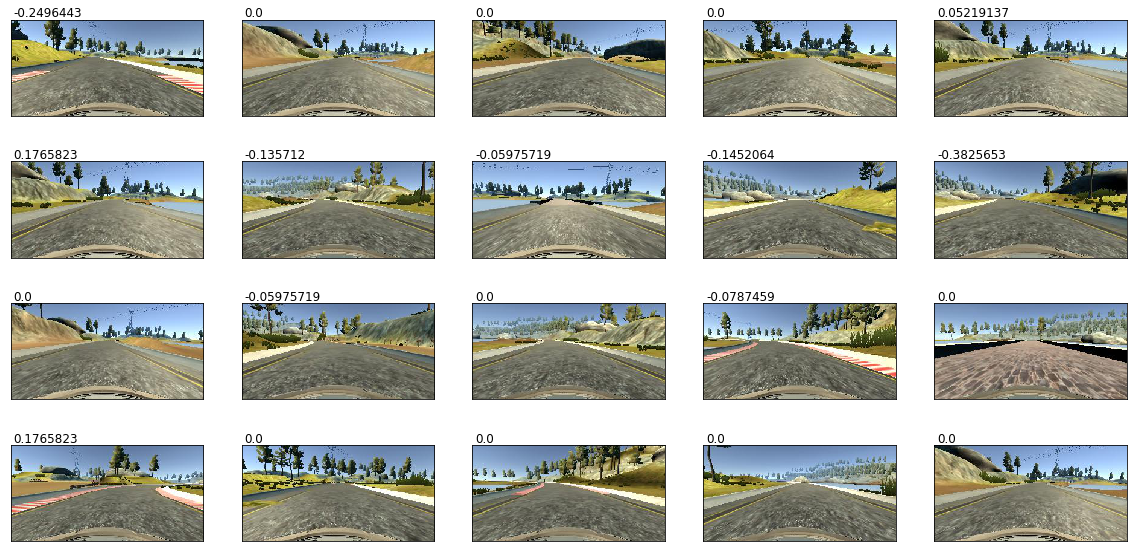

In [9]:
N_IMGS = 20 # number of images to display
ls_imgs = np.random.choice(np.arange(len(log)), size = N_IMGS, replace=False)

NR = 4 #number of rows for display
_, ax = plt.subplots(NR, N_IMGS // NR, figsize=(20,10))

print()
for n, idx in enumerate(ls_imgs): 
    img = cv2.imread(DATA_PATH + center_im[idx])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    row, col = divmod(n, N_IMGS // NR)
    
    ax[row, col].imshow(img)
    ax[row, col].text(4, -5, steering_rad[idx], fontsize=12)    
    ax[row, col].get_xaxis().set_visible(False)
    ax[row, col].get_yaxis().set_visible(False)

plt.show()

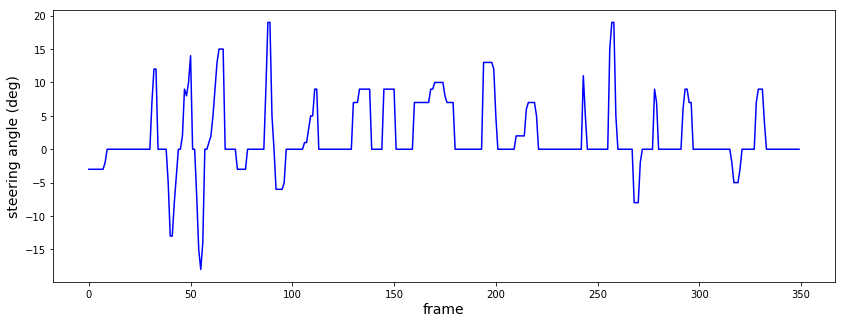

In [10]:
steering_deg = np.rad2deg(steering_rad).astype(int)

NBI = 350
plt.figure(figsize=(14,5))
plt.plot(np.arange(NBI), steering_deg[100:100+NBI], 'b-')
plt.xlabel('frame', fontsize=14)
plt.ylabel('steering angle (deg)', fontsize=14)
plt.show()

## Data Exploration

- Steering angle of 0 has the highest occurence.
-  There are more positive angle values than negative ones.

In [11]:
unique_st_angles, counts = np.unique(steering_deg, return_counts=True)
# get unique values
print('Number of unique angles value : {}'.format(len(unique_st_angles)) )

Number of unique angles value : 74


In [12]:
unique_st_angles

array([-54, -53, -52, -46, -44, -41, -39, -36, -34, -30, -28, -27, -26,
       -25, -24, -23, -22, -21, -20, -19, -18, -17, -16, -15, -14, -13,
       -12, -11, -10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,
         1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  33,  35,  36,  37,  41,  57])

In [13]:
counts

array([   2,    1,    1,    1,    1,    1,    2,    2,    2,    3,   14,
          1,    3,   29,    5,   18,   10,   18,    9,    9,   23,   52,
         38,   49,   21,   45,   97,   15,   16,   56,  228,   77,   88,
        103,  150,  281,  107,   87, 4557,   85,  198,   71,  119,  231,
         42,  135,   31,  205,  274,   42,   30,   19,   14,   62,   22,
         54,   17,   30,   36,   32,    3,   10,    4,    1,   16,    7,
          4,    6,    6,    1,    3,    1,    1,    2])

### There are many zeros !

In [14]:
counts[unique_st_angles == 0]

array([4557])

In [15]:
len(steering_deg)

8036

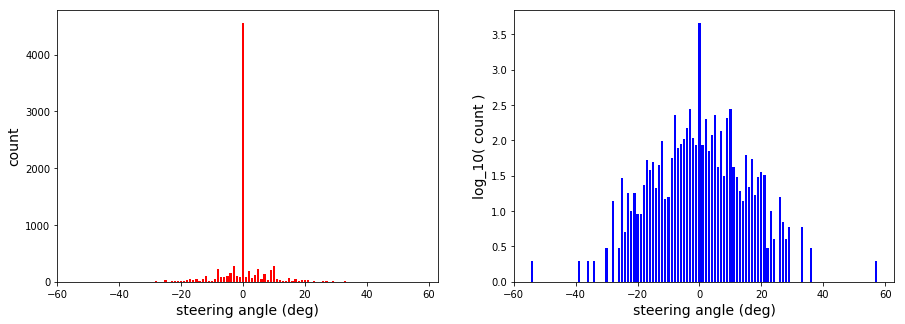

Count of positive angles: 1814 | zero angle: 4557 | negative angles: 1665


In [16]:
#plot histogram
_, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].bar(unique_st_angles, counts, width=.7, color='r')
ax[0].set_xlabel('steering angle (deg)', fontsize=14)
ax[0].set_ylabel('count', fontsize=14)


ax[1].bar(unique_st_angles, np.log10(counts), width=.7, color='b')
plt.xlabel('steering angle (deg)', fontsize=14)
plt.ylabel('log_10( count )', fontsize=14)

plt.show()

cnt_neg = np.sum(steering_deg < 0)
cnt_zero = np.sum(steering_deg == 0)
cnt_pos = np.sum(steering_deg > 0)
print('Count of positive angles: {} | zero angle: {} | negative angles: {}'.format(cnt_pos, cnt_zero, cnt_neg))

# DATA AUGMENTATION

let's try a few ideas for generating new training examples

## Horizontal flipping

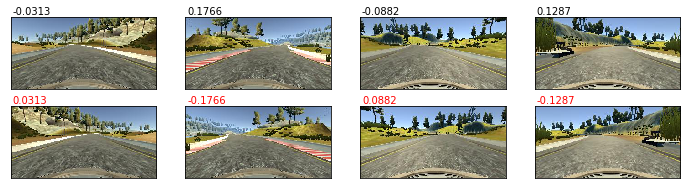

In [17]:
N_IMGS = 4
ls_imgs = np.random.choice(np.arange(len(log)), size = N_IMGS, replace=False)

NR = 2 #number of rows for display : one for the normal images, one for the flipped versions
_, ax = plt.subplots(NR, N_IMGS, figsize=(12, 3))
col, row = 0, 0

for col, idx in enumerate(ls_imgs): 
    img = cv2.imread(DATA_PATH + center_im[idx])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    ax[0, col].imshow(img)
    ax[0, col].text(3, -5, '{:.4f}'.format(steering_rad[idx]), fontsize=10, color='black')
    ax[0, col].get_xaxis().set_visible(False)
    ax[0, col].get_yaxis().set_visible(False)

    ax[1, col].imshow(cv2.flip(img, 1))
    ax[1, col].text(4, -5, '{:.4f}'.format(- steering_rad[idx]), fontsize=10, color='red')
    ax[1, col].get_xaxis().set_visible(False)
    ax[1, col].get_yaxis().set_visible(False)
    
plt.show()

## Variation of brightness

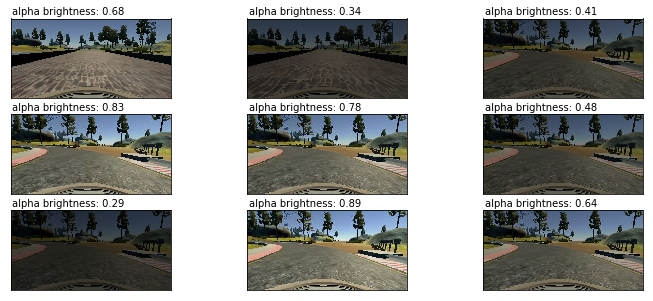

In [18]:
N_IMGS = 1
ls_imgs = np.random.choice(np.arange(len(log)), size = N_IMGS, replace=False)

NB_VAR = 9 #number of variations in brightness
NR = 3 #number of rows for display
_, ax = plt.subplots(NR, NB_VAR // NR, figsize=(12, 5))


for idx in range(NB_VAR): 
    img_adress = DATA_PATH + center_im[idx]
    img = cv2.imread(img_adress)
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    alpha = np.random.uniform(low=.2, high=.999, size=None)
    hsv[:,:,2] = (hsv[:,:,2] * alpha).astype('uint8')
    rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    
    row, col = divmod(idx, NB_VAR // NR)
    ax[row, col].imshow(rgb)
    
    ax[row, col].text(3, -8, 'alpha brightness: {:.2f}'.format(alpha), fontsize=10, color='black')
    ax[row, col].get_xaxis().set_visible(False)
    ax[row, col].get_yaxis().set_visible(False)

plt.show()

# Image cropping

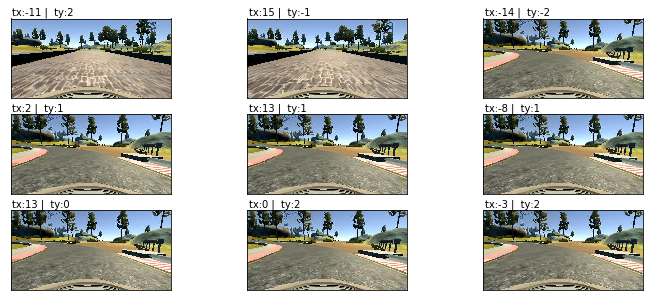

In [19]:
N_IMGS = 1
ls_imgs = np.random.choice(np.arange(len(log)), size = N_IMGS, replace=False)

NB_VAR = 9 #number of variations in crop
NR = 3 #number of rows for display
_, ax = plt.subplots(NR, NB_VAR // NR, figsize=(12, 5))


for idx in range(NB_VAR): 
    img_adress = DATA_PATH + center_im[idx]
    img = cv2.imread(img_adress)
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    tx_min=-20
    tx_max=20
    ty_lower=-2
    ty_upper=2
    shape = img.shape
    col_start, col_end = abs(tx_min), shape[1]-tx_max
    horizon, bonnet = 60, 136
    tx = np.random.randint(tx_min, tx_max+1)
    ty = np.random.randint(ty_lower, ty_upper+1)

    #cropping
    random_crop = img[horizon+ty:bonnet+ty, col_start+tx:col_end+tx, :]
    
    row, col = divmod(idx, NB_VAR // NR)
    ax[row, col].imshow(img)
    ax[row, col].text(3, -8, "tx:{} |  ty:{}".format(tx, ty), fontsize=10, color='black')
    ax[row, col].get_xaxis().set_visible(False)
    ax[row, col].get_yaxis().set_visible(False)

plt.show()

## Image shearing

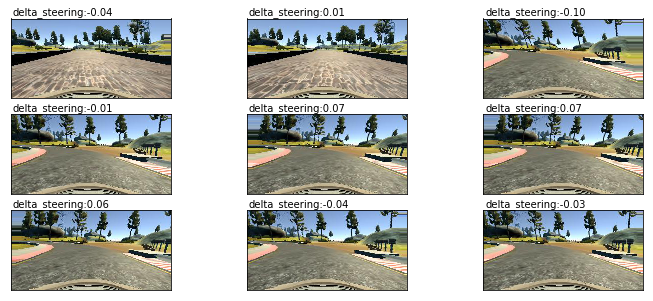

In [20]:
N_IMGS = 1
ls_imgs = np.random.choice(np.arange(len(log)), size = N_IMGS, replace=False)

NB_VAR = 9 #number of variations in crop
NR = 3 #number of rows for display
_, ax = plt.subplots(NR, NB_VAR // NR, figsize=(12, 5))


for idx in range(NB_VAR): 
    img_adress = DATA_PATH + center_im[idx]
    img = cv2.imread(img_adress)
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    shear_range = 20
    rows, cols, ch_ = img.shape
    dx = np.random.randint(-shear_range, shear_range + 1)

    random_point = [cols//2+ dx, rows//2]
    pts1 = np.float32([[0,rows], [cols,rows], [cols//2,rows//2]])
    pts2 = np.float32([[0,rows], [cols,rows], random_point])
   
    M = cv2.getAffineTransform(pts1,pts2)
    img = cv2.warpAffine(img,M,(cols,rows),borderMode=1)
    
    delta_steering = dx/(rows/2) * 360/(2*np.pi*25.0) / 6.0
    
    row, col = divmod(idx, NB_VAR // NR)
    ax[row, col].imshow(img)
    ax[row, col].text(3, -8, "delta_steering:{:.2f}".format(delta_steering), fontsize=10, color='black')
    ax[row, col].get_xaxis().set_visible(False)
    ax[row, col].get_yaxis().set_visible(False)

plt.show()

In [21]:
CROPPED_DIM = 64

def random_crop(image, steering=0.0, tx_min=-20, tx_max=20, ty_min=-2, ty_max=2, rand=True):
    """
    We will randomly crop subsections at the approximate center of the image and use them as our data set.
    After that we downside the resulting image to 64x64.
    """
    
    col_start, col_end = abs(tx_min), image.shape[1] - tx_max
    horizon, bonnet = 60, 136

    if rand:
        tx = np.random.randint(tx_min, tx_max+1)
        ty = np.random.randint(ty_min, ty_max+1)
    else:
        tx, ty = 0, 0
    
    #cropping
    random_crop = image[horizon+ty:bonnet+ty, col_start+tx:col_end+tx, :]
    
    #downsizing
    image = cv2.resize(random_crop,(CROPPED_DIM,CROPPED_DIM), cv2.INTER_AREA)
    
    # the steering variable needs to be updated to counteract the shift 
    delta_steering = -tx/(tx_max - tx_min)/3.0 if tx_min != tx_max else 0 
    steering += delta_steering
    
    return image, steering


def random_shear(image, steering, shear_range=40):
    rows, cols, ch_ = image.shape
    
    dx = np.random.randint(-shear_range, shear_range + 1)

    random_point = [cols//2+ dx, rows//2]
    pts1 = np.float32([[0,rows], [cols,rows], [cols//2,rows//2]])
    pts2 = np.float32([[0,rows], [cols,rows], random_point])
   
    M = cv2.getAffineTransform(pts1,pts2)
    image = cv2.warpAffine(image,M,(cols,rows),borderMode=1)
    
    delta_steering = dx/(rows/2) * 360/(2*np.pi*25.0) / 6.0     
    steering += delta_steering
    
    return image, steering


def random_brightness(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    alpha = np.random.uniform(low=.2, high=.9, size=None)
    hsv[:,:,2] = (hsv[:,:,2] * alpha).astype('uint8')
    rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    
    return rgb


def random_flip(image,steering):
    coin=np.random.randint(0, 2)
    if coin == 0:
        image = cv2.flip(image,1)
        steering = -steering
    
    return image, steering

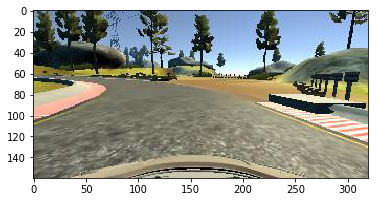

In [22]:
def read_image_and_steering(idx, cam_choice, left_im_, center_im_, right_im_, steer):
    """
    idx: index of image
    cam_choice: center_im / left_im / right_im
    """
    assert cam_choice in 'LCR'
    offset = 1.2 
    dist = 100.0
    
    cam = {'C':center_im_, 'L':left_im_, 'R':right_im_}[cam_choice]
    image = cv2.imread(DATA_PATH + cam[idx].strip()) #beware of leading whitespaces!
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    if cam_choice == 'C':
        delta_steering = 0
    elif cam_choice == 'L':
        delta_steering = -offset/dist * 360/(2*np.pi)/25.0        
    elif cam_choice == 'R':
        delta_steering = offset/dist * 360/(2*np.pi)/25.0 

    steering = steer[idx] + delta_steering
    
    return image, steering

#try
cam_choice = random.choice('LCR')   
image, steering = read_image_and_steering(10, cam_choice, left_im, center_im, right_im, steering_rad)

plt.imshow(image)

# Steering angle prediction

In [23]:
training_dat[['left','center','right']].head(2)

,left,center,right
0,IMG/left_2016_12_01_13_30_48_287.jpg,IMG/center_2016_12_01_13_30_48_287.jpg,IMG/right_2016_12_01_13_30_48_287.jpg
1,IMG/left_2016_12_01_13_30_48_404.jpg,IMG/center_2016_12_01_13_30_48_404.jpg,IMG/right_2016_12_01_13_30_48_404.jpg


## creation of the training & validation sets

In [24]:
X_train = training_dat[['left','center','right']]
Y_train = training_dat['steering']

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=42)

In [25]:
# we convert the input data into Numpy arrays
X_left  = X_train['left'].as_matrix()
X_right = X_train['right'].as_matrix()
X_train = X_train['center'].as_matrix()

Y_train = Y_train.as_matrix().astype(np.float32) #we don't need float64

#for validation, we only keep the center image
X_val = X_val['center'].as_matrix()

Y_val = Y_val.as_matrix().astype(np.float32) #we don't need float64

In [26]:
%xdel training_dat

In [27]:
print('X_train[:5]:\n',X_train[:5])
print()
print('Y_train[:5]:\n',Y_train[:5])

X_train[:5]:
 ['IMG/center_2016_12_01_13_39_58_081.jpg'
 'IMG/center_2016_12_01_13_35_47_206.jpg'
 'IMG/center_2016_12_01_13_42_14_300.jpg'
 'IMG/center_2016_12_01_13_33_56_606.jpg'
 'IMG/center_2016_12_01_13_38_30_847.jpg']

Y_train[:5]:
 [-0.4490258   0.0904655   0.         -0.401554   -0.05026283]


training example at index: 7034
L/C/R: R
steering: -0.032255217521542826
steering: 0.05846310004083752
steering: 0.00012976670750419056
steering: 0.00012976670750419056
steering: 0.0001297667040489614


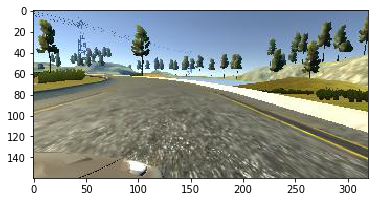

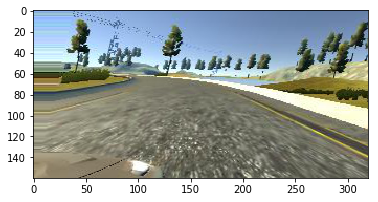

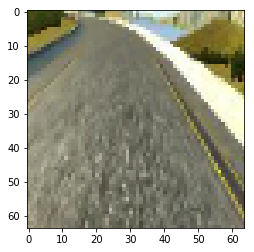

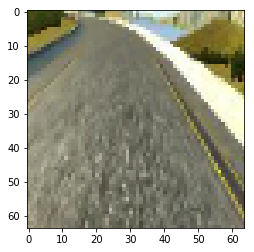

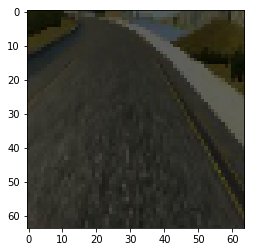

In [28]:
def generate_training_example(left_im_, center_im_, right_im_, steer, drop_small_angle_prob = 0.95, verbose=False):
    """
    drop_small_angle_prob =  2 : we drop all examples with a 0 angle
    drop_small_angle_prob = -1 : we keep all examples with a 0 angle
    """
    
    ONE_DEGREE_THRESHOLD = 0.0175 #one degree in radian
    while True:
        idx = np.random.randint(0, len(steer))
        if np.absolute(steer[idx]) > ONE_DEGREE_THRESHOLD or \
            np.random.uniform(0,1) > drop_small_angle_prob: #we keep only very few training examples with a ~0 steering angle
            break
    
    if verbose:
        print('training example at index: {}'.format(idx))
    
    lcr = random.choice('LCR')
    if verbose:    
        print('L/C/R: {}'.format(lcr))
    
    image, steering = read_image_and_steering(idx, lcr, left_im_, center_im_, right_im_, steer)
    if verbose:
        print('steering: {}'.format(steering))
        plt.imshow(image)
        
    image, steering = random_shear(image, steering, shear_range=40)
    if verbose:
        print('steering: {}'.format(steering))
        plt.figure()
        plt.imshow(image)    
    
    image, steering = random_crop(image, steering)
    if verbose:
        print('steering: {}'.format(steering))
        plt.figure()
        plt.imshow(image)
    
    image, steering = random_flip(image,steering)
    if verbose:
        print('steering: {}'.format(steering))
        plt.figure()
        plt.imshow(image)
    
    image = random_brightness(image)
    if verbose:
        plt.figure()
        plt.imshow(image)
    
    return image.astype('uint8'), steering.astype('float32')
    

image, steering = generate_training_example(X_train, X_left, X_right, Y_train, verbose=True)
plt.imshow(image)    
print('steering: {}'.format(steering))

In [29]:
def get_validation_set(X_val, Y_val):
    
    images = np.empty((len(X_val), CROPPED_DIM, CROPPED_DIM,3), dtype='uint8')
    steerings = np.empty(len(X_val), dtype='float32')
    for i in range(len(X_val)):
        #quick hack: we put 'None' as the left and right cam images for the validation set,
        #and we always chose 'C' for the center camera.
        image, steering = read_image_and_steering(i, 'C', None, X_val, None, Y_val)
        
        #hack: we do not crop images for the validation set: all cropping params are set to 0.
        #TODO : set 'rand=False' param
        images[i], steerings[i] = random_crop(image, steering, tx_min=0, tx_max=0, ty_min=0, ty_max=0)
    
    return images, steerings

In [30]:
def generate_training_batch(left_im_, center_im_, right_im_, steer, batch_size = 32):
    
    batch_images = np.empty((batch_size, CROPPED_DIM, CROPPED_DIM, 3), dtype='uint8')
    batch_steerings = np.empty(batch_size, dtype='float32')
    while True:
        for i in range(batch_size):
            image, steering = generate_training_example(left_im_, center_im_, right_im_, steer)
            batch_images[i] = image
            batch_steerings[i] = steering
            
        yield batch_images, batch_steerings

# CNN model

In [31]:
model = Sequential()
model.add(Lambda(lambda x: x/127.5 - 1.0,input_shape=(CROPPED_DIM,CROPPED_DIM,3)))
model.add(Convolution2D(32, 8,8 ,border_mode='same', subsample=(4,4)))
model.add(Activation('relu'))
model.add(Convolution2D(64, 8,8 ,border_mode='same',subsample=(4,4)))
model.add(Activation('relu',name='relu2'))
model.add(Convolution2D(128, 4,4, border_mode='same',subsample=(2,2)))
model.add(Activation('relu'))
model.add(Convolution2D(128, 2,2, border_mode='same',subsample=(1,1)))
model.add(Activation('relu'))
model.add(Flatten())

model.add(Dropout(0.5))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(128))
model.add(Dense(1))

model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 64, 64, 3)     0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 16, 16, 32)    6176        lambda_1[0][0]                   
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 16, 16, 32)    0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 4, 4, 64)      131136      activation_1[0][0]               
___________________________________________________________________________________________

In [32]:
BATCH_SIZE = 256

train_generator = generate_training_batch(X_left, X_train, X_right, Y_train, batch_size=BATCH_SIZE)

X_val, Y_val = get_validation_set(X_val,Y_val)

In [33]:
Y_train[12]

-0.04076847

In [34]:
#quick checks:
print('X_train data type:', X_train.dtype)
print('Y_train data type:', Y_train.dtype)
print('X_val data type:', X_val.dtype)
print('Y_val data type:', Y_val.dtype)

X_train data type: object
Y_train data type: float32
X_val data type: uint8
Y_val data type: float32


## Let's start the training!

In [56]:
adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(optimizer=adam, loss='mse')

NB_EPOCH = 3

t0 = time.time()

history_object = model.fit_generator(train_generator,
                    samples_per_epoch= 20000, #len(Y_train),
                    nb_epoch=NB_EPOCH,
                    validation_data=(X_val,Y_val),
                    verbose=1)

print("\nTraining time:", time.time() - t0)

Epoch 1/3
19968/20000 [============================>.] - ETA: 0s - loss: 0.0302

/Users/sebastienvincent/.virtualenvs/nd013/lib/python3.6/site-packages/keras/engine/training.py:1569: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


20224/20000 [==============================] - 52s - loss: 0.0301 - val_loss: 0.0109
Epoch 2/3
20224/20000 [==============================] - 52s - loss: 0.0301 - val_loss: 0.0109
Epoch 3/3
20224/20000 [==============================] - 50s - loss: 0.0301 - val_loss: 0.0104

Training time: 157.04120087623596


In [61]:
model.save('model.h5')

launch sim with `python drive.py model.h5`